In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [87]:
dataset = pd.read_csv("train.csv")
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
# Drop the specified columns
columns_to_drop = ['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked']
dataset = dataset.drop(columns=columns_to_drop)

# Create a new column 'FamilySize' by adding 'SibSp' and 'Parch'
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']
dataset = dataset.drop(columns=['SibSp', 'Parch'])

# Define the bins for age ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=bins, labels=labels, right=False)

dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,FamilySize,AgeGroup
0,1,0,3,male,22.0,1,20-30
1,2,1,1,female,38.0,1,30-40
2,3,1,3,female,26.0,0,20-30
3,4,1,1,female,35.0,1,30-40
4,5,0,3,male,35.0,0,30-40


In [89]:
dataset_cleaned = dataset.dropna()
dataset_encoded = pd.get_dummies(dataset_cleaned, columns=['Sex', 'AgeGroup'])

dataset_encoded.head()

,PassengerId,Survived,Pclass,Age,FamilySize,Sex_female,Sex_male,AgeGroup_0-10,AgeGroup_10-20,AgeGroup_20-30,AgeGroup_30-40,AgeGroup_40-50,AgeGroup_50-60,AgeGroup_60-70,AgeGroup_70-80,AgeGroup_80-90
0,1,0,3,22.0,1,False,True,False,False,True,False,False,False,False,False,False
1,2,1,1,38.0,1,True,False,False,False,False,True,False,False,False,False,False
2,3,1,3,26.0,0,True,False,False,False,True,False,False,False,False,False,False
3,4,1,1,35.0,1,True,False,False,False,False,True,False,False,False,False,False
4,5,0,3,35.0,0,False,True,False,False,False,True,False,False,False,False,False


In [90]:
X, y = (dataset_encoded.drop(columns=['Survived']), dataset_encoded['Survived'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


In [91]:
names = [
    "Logistic Regression",
    "Naive Bayes",
    "KNN",
    "Linear SVM",
    "SVM RBF kernel",
    "MLP 1 hidden layer",
    "MLP 2 hidden layer",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting"
]

classifiers = [
    LogisticRegression(),
    GaussianNB(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100,), alpha=1, max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100, 100), alpha=1, max_iter=1000, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
]

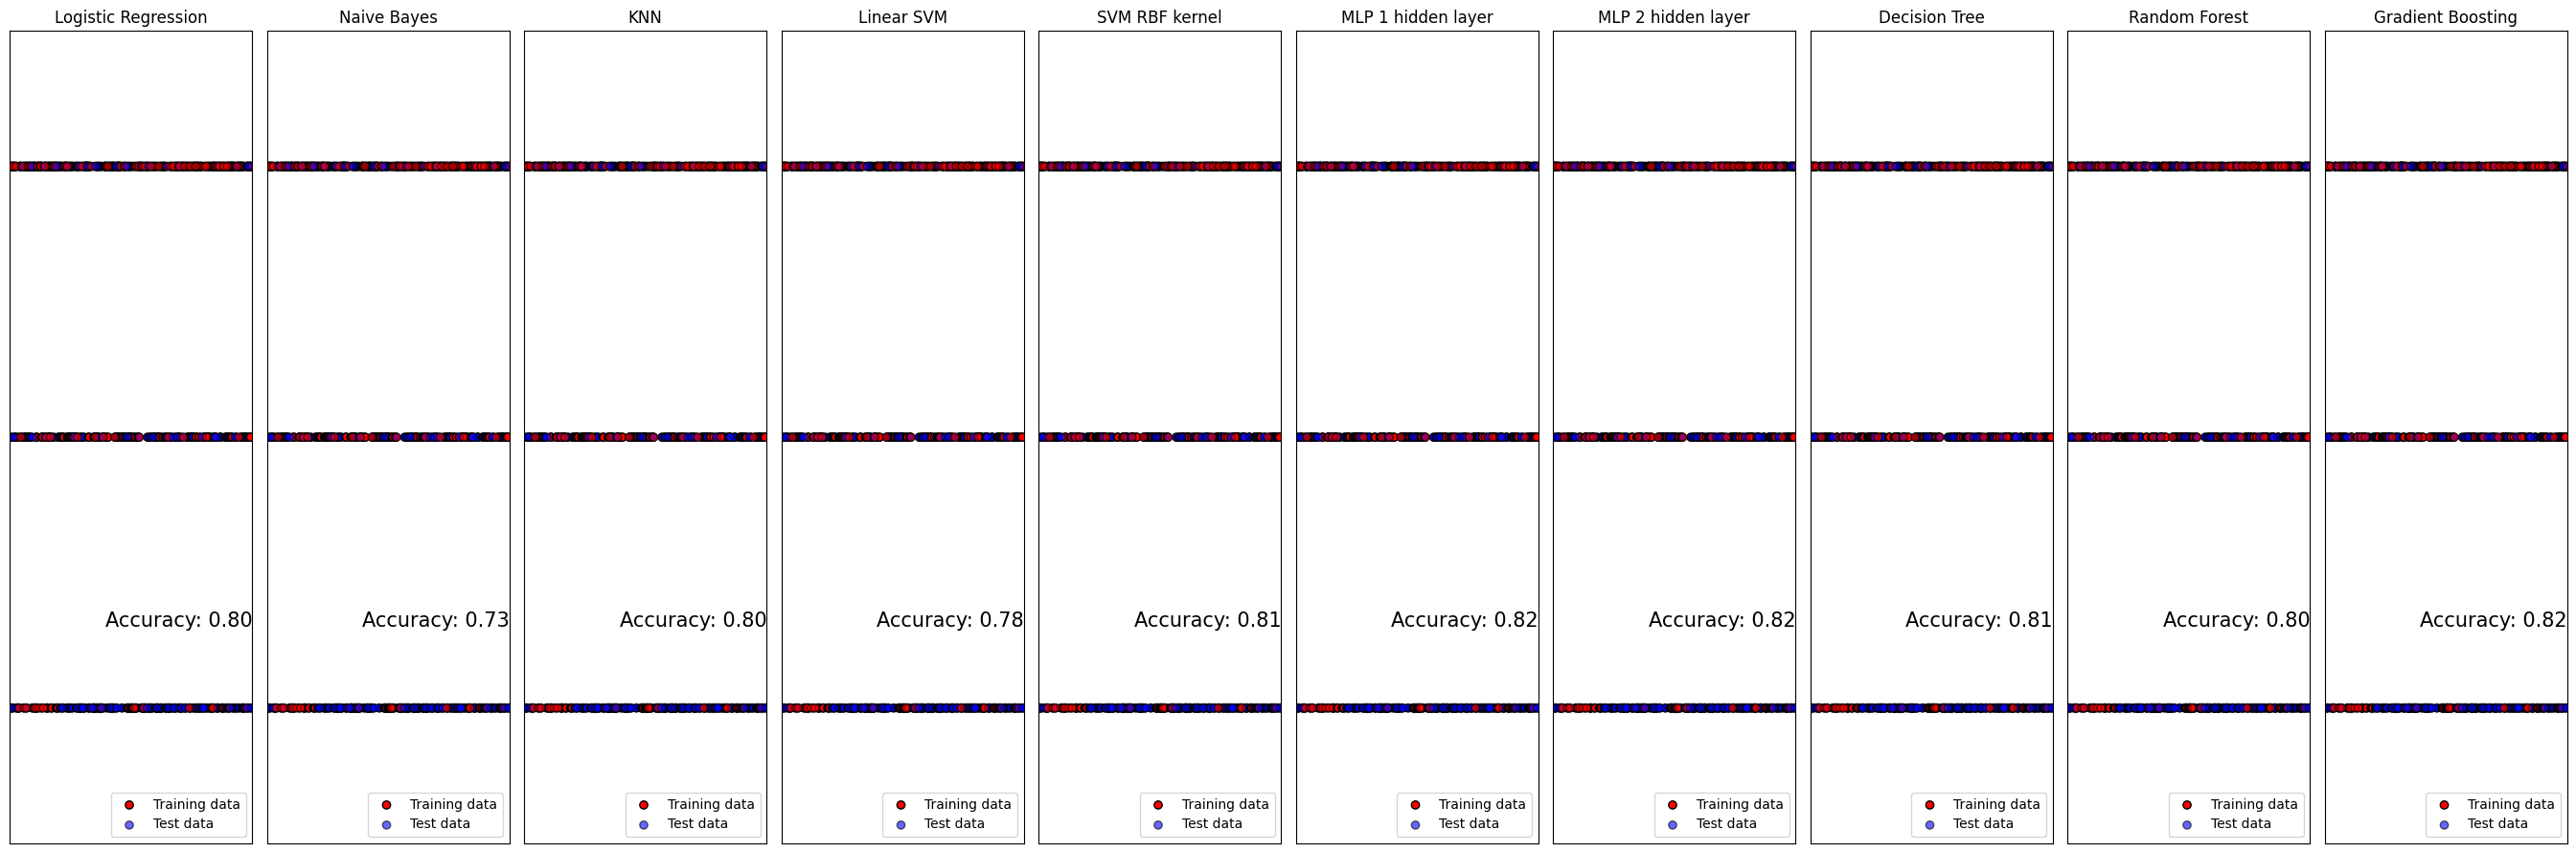

In [92]:
figure = plt.figure(figsize=(27, 9))
n_classifiers = len(classifiers)

# Plotting
for i, clf in enumerate(classifiers):
    ax = plt.subplot(1, n_classifiers, i + 1)
    clf = make_pipeline(StandardScaler(), clf)
    
    # Track scores for each fold
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the classifier and calculate accuracy
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    # Calculate average score across folds
    avg_score = np.mean(scores)
    
    # Scatter plot
    ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", label="Training data")
    ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k", label="Test data")
    ax.set_xlim(X.values[:, 0].min() - 0.5, X.values[:, 0].max() + 0.5)
    ax.set_ylim(X.values[:, 1].min() - 0.5, X.values[:, 1].max() + 0.5)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])
    ax.text(X.values[:, 0].max() - 0.3, X.values[:, 1].min() + 0.3, f"Accuracy: {avg_score:.2f}", size=15, horizontalalignment="right")
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
